# 1. Import all required Modules and custom build Classes into the Jupyter notebook
Import all required modules for the project.<br />
Import all custom modules for the project and instantiate classes using the config file.<br />
Custom modules can now be called directly in the notebook.


In [2]:
import sys
from sys import getsizeof as dictsize
import os
import json
import time
import pymongo
import urllib
import pandas as pd
import numpy as np
import urllib
import urllib.request
import missingno as msno
import zipfile 
import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import requests

try:
    import createNewData.data.config as in_config
    from createNewData.pypackages.Azure import Azure
    from createNewData.pypackages.urlHandler import UrlHandler
    AzurePackage = Azure(in_config)
    Url = UrlHandler(in_config)
    
    
except ImportError as e:
    print(in_config.FailedImport)
    print(e)

# 2. Upload to SQL Database
Download the entire GTFS data and upload to the Azure SQL Database.
Required fields:
* "UploadToSQL": The class name for the Azure constructor for uploading tables to the database.
* GTFSDF:  The dataframes to be written to the database.
* tablename: The name of the new table to be created.
* teamConnQuote: The connection string for the team SQL Database obtained from the config file.

In [ ]:
GTFS = requests.get(in_config.GTFSURL, stream=True)
GTFSRaw = zipfile.ZipFile(io.BytesIO(GTFS.content))

for each in GTFSRaw.namelist():
    GTFSDF = pd.read_csv(GTFSRaw.open(each), low_memory=False)
    tableName = each.replace(".txt","")
    AzurePackage("UploadToSQL",
                  GTFSDF,
                  tableName,
                  in_config.teamConnQuote)

# 3. Create Request Batches
1. Collect all items in the 'stops' schema of the shared team Database.
2. Reduce Dataframe by removing dupicate coordinates.
3. Pop() coordinates based on batch sizes no greater than 1024 bytes.
4. Add each coordinate to a list of batches to send the the Open-elevations API

### Attributes
* Azure class imported with call functionality (in)
* Config File (in)
* listOfBatches (out)


In [ ]:
listOfBatches = []
batches = {"locations" : []}

try:
    rawShapedf = AzurePackage("SelectAllData", "stops")
    shapesDF = rawShapedf[["stop_id", "stop_lat","stop_lon"]]
    shapesRequest = shapesDF.drop_duplicates(subset=None, 
                                            keep='first', 
                                            inplace=False)
    shapesCoordinates = Url("generateLocationRequest", shapesRequest)
    for key, value in shapesCoordinates.items():
        if key == "locations":
            locations = value
    while len(locations) != 0:
        for each in locations:
            if dictsize(batches["locations"]) +\
                                dictsize(each) +\
                                dictsize(batches) < 9700:
                location = locations.pop(0)
                batches["locations"].append(location)
            else:
                location = locations.pop(0)
                batches["locations"].append(location)
                listOfBatches.append(batches)
                batches = {"locations" : []}
        for each in listOfBatches:
            if dictsize(each) > 10000:
                raise Exception(in_config.RequestToBig)
            else:
                pass
    else:
        print("All values added to the list of requests.")
except pd.io.sql.DatabaseError as e:
    print(in_config.NoSQLShema)

except urllib.request.HTTPError as e:
    if e.code == "403":
        print(in_config.SQLConnectionFail)
    
except Exception as e:
    print(in_config.UNKMGO)
    print(e)


# 4. Send Request Batches
1. Send all request in the list of request batches to the API and store them into a a dataframe. <br>
2. Upload the dataframe to the database, replacing any existing schema with the same table name. <br>

### Attributes
* Azure class imported with call functionality (in)
* Config File (in)
* List of request batches (in)

In [ ]:
listOfObjects = []
listOfElevations = []
ListOfDicts = []

print(f"There are {len(listOfBatches)} batches to collect.")

Iteration = 0
try:
    for each in listOfBatches:
            attempts = 0
            while attempts < 5:
                try:
                    ListOfDicts.append(Url("mineElevationData",each))
                    break
                except urllib.error.HTTPError:
                    attempts = attempts+1
            Iteration = Iteration + 1
            print(f"Elevation {Iteration} Collected")
            time.sleep(2)
    for each in ListOfDicts:
        for key, value in each.items():
            if type(value) is list:
                listOfObjects.append(value)

    for each in listOfObjects:
        for elevation in each:
            listOfElevations.append(elevation)
            Iteration = Iteration +1
    df = pd.DataFrame(listOfElevations)
    dfTrimmed = df.drop_duplicates()
    try:
        sumElevation = dfTrimmed["elevation"].sum()
    except: 
        raise Exception("Failed to collect all elevations, please try again.")
    print(dfTrimmed.head())
except KeyError as e:
    print(f"Column {e} cannot be found in the dataframe.")
except NameError as e:
    print(f"The Datatable {e} cannot be found.")
except Exception as e:
    print(in_config.UNKMGO)
    print(type(e))
    print(e)


# 5. Save Trimmed Elevation Data Team SQL Database
This reads data from the raw Json files in the MongoDB database and imports them to a dataframe that contains only unique values. Removing any rows where any full row duplicates exist.
This saves the resulting SQL schemata to the Database used by the R-Shiny app. (Production)
This will overwrite any existing data in the SQL schemata that already exists.

In [ ]:
SqlDataCursor = AzurePackage("UploadToSQL",
                              dfTrimmed,
                              "elevations",
                              in_config.teamConnQuote)

# 6. Collect real time data and upload to Mongo
Collect the real time data as a json file and overwrites the collection in the NoSQL database.
* URL used https://gtfsr.transportforireland.ie
* Azure cosmos was initially used but this turned out to be insufficient when storing larger data sets that occure earlier in the day. A Casandra database would be better suited to the RTI data as it can accept uploads greater than 2MB.

In [ ]:
url = in_config.url2
headers = in_config.RTIheaders
response = Url("callURL", url, {}, headers)
JsonData = response.read().decode('utf8').replace("'", '"')
RTIgtfs = json.loads(JsonData)
try:
    AzurePackage("UploadToMongo","RTIgtfs",RTIgtfs)
except pymongo.errors.WriteError as e:
    print("An error occured while attempting to write the GTFS data to Mongo Database.")
    print(type(e))
except HTTPError as e:
    print("An error occured while attempting to connect to the CosmosDB Database.")
    print(type(e))


# 8. For Single Use SQL Queries
Send SQL queries to team shared SQL database. <br>
**This script is for development purposes only.**


In [5]:
conn = AzurePackage("AzureDBConn", in_config.teamConnQuote)
SQLString = """Select * FROM stops"""
stopdf = pd.read_sql(SQLString, conn)
print(stopdf.head())
conn.close()

        stop_id                    stop_name   stop_lat  stop_lon
0  8220DB000002  Parnell Square West, stop 2  53.352244 -6.263723
1  8220DB000003  Parnell Square West, stop 3  53.352309 -6.263811
2  8220DB000004  Parnell Square West, stop 4  53.352575 -6.264175
3  8220DB000006  Parnell Square West, stop 6  53.352749 -6.264454
4  8220DB000007  Parnell Square West, stop 7  53.352841 -6.264570


# 9. Test For Missing Elevation Data
Display all missing data in elevations when joined to the distances and stops schemata.
White lines in the elevation column indicates missing data in the elevation column.

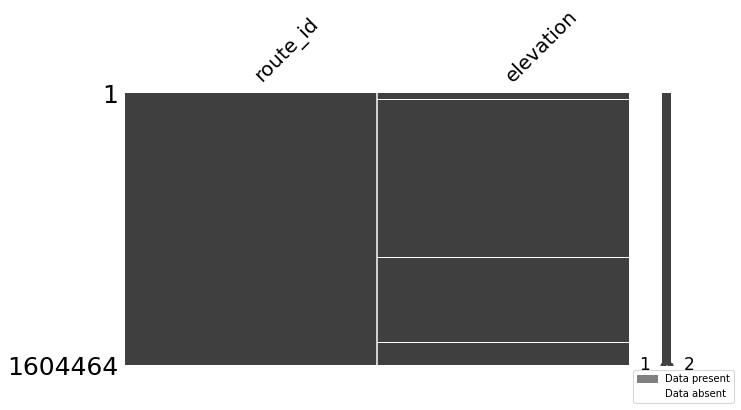

In [4]:
conn = AzurePackage("AzureDBConn", in_config.teamConnQuote)
SQLTest = """SELECT distances.route_id, 
                     distances.service_id, 
                     distances.quasi_block,
                     distances.time_axis,
                     stopEelevations.elevation
               FROM distances
               LEFT JOIN stops ON distances.stop = stops.stop_id
               LEFT JOIN stopEelevations ON stops.stop_lat = stopEelevations.latitude AND
               stops.stop_lon = stopEelevations.longitude
               """
merged = pd.read_sql(SQLTest, conn)
msno.matrix(merged[["route_id","elevation"]], figsize=(10,5), fontsize=20)
gray_patch = mpatches.Patch(color='gray', label='Data present')
white_patch = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray_patch, white_patch],loc='upper left', bbox_to_anchor=(1, 0))
plt.show()

conn.close()


# 10. Generate Plot for Elevations Over Time
1. Call all rows from the distnaces schema in the team database where the route and block are specified
2. Connect the stop_id's in the distances schema to their relevent elevations in the stopEelevations schema.
3. Plot the elevations values over time.


Text(0, 0.5, 'Elevations')

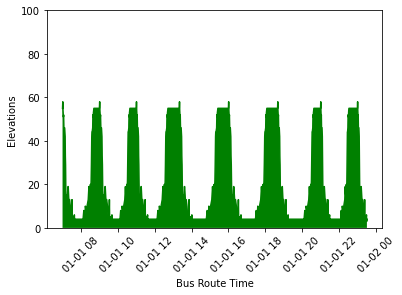

In [3]:
import matplotlib.pyplot as plt
import datetime as dt
conn = AzurePackage("AzureDBConn", in_config.teamConnQuote)
SQLTest = """SELECT distances.route_id, 
                     distances.service_id, 
                     distances.quasi_block,
                     distances.time_axis,
                     stopEelevations.elevation
               FROM distances
               LEFT JOIN stops ON distances.stop = stops.stop_id
               LEFT JOIN stopEelevations ON stops.stop_lat = stopEelevations.latitude AND
               stops.stop_lon = stopEelevations.longitude
               WHERE distances.route_id = '60-1-d12-1'
               AND distances.service_id = 'y1003'
               AND distances.quasi_block = '1.0'
               """
merged = pd.read_sql(SQLTest, conn)
conn.close()

elevationArray = merged[["elevation"]].values.flatten()
timeArray = merged[["time_axis"]].values.flatten()


d = merged["time_axis"].dt.to_pydatetime()
plt.plot_date(timeArray,elevationArray, "-",color='green')
plt.fill_between(timeArray, elevationArray, where=elevationArray>0, facecolor='green')
plt.ylim([0,100])
plt.xticks(rotation=45)
plt.xlabel("Bus Route Time")
plt.ylabel("Elevations")
